First, go to Kaggle and download the dataset. Here's the link: https://www.kaggle.com/c/dog-breed-identification  
We only use the train data.

## data preprocessing

In [1]:
import pandas as pd
import os
import shutil

labels=pd.read_csv("labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [2]:
breeds=list(labels['breed'].unique())
len(breeds)

120

In [13]:
## divide the train data into different folders according to their breed names
os.mkdir('new_train')

for i in range(len(labels)):
    if labels['breed'][i] not in os.listdir('new_train'):
        os.mkdir('new_train/'+labels['breed'][i])
    shutil.move('train/'+labels['id'][i]+'.jpg', 'new_train/'+labels['breed'][i])

In [14]:
import random
import numpy as np

os.chdir('new_train')

# split data into train(80%), val(10%), test(10%)
for i in ['train','val','test']:
    os.mkdir(i)

for i in breeds:
    os.mkdir('train/'+i)
    os.mkdir('val/'+i)
    os.mkdir('test/'+i)
    breed_i=os.listdir(i)
    a=list(range(len(breed_i)))
    np.random.shuffle(a)
    idx1=round(len(breed_i)*0.8)
    idx2=round(len(breed_i)*0.9)
    train=list(pd.Series(breed_i)[a[:idx1]])
    val=list(pd.Series(breed_i)[a[idx1:idx2]])
    test=list(pd.Series(breed_i)[a[idx2:]])
    for t in train:
        shutil.move(i+'/'+t, 'train/'+i)
    for v in val:
        shutil.move(i+'/'+v, 'val/'+i)
    for te in test:
        shutil.move(i+'/'+te, 'test/'+i)

Now, let's create another folder called **train_val_test**, and copy train folder, val folder, and test folder to it.

## some functions

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm
import numpy as np

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

C:\Users\cuiti\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split

# define function to load train, test, and validation datasets
def load_dataset(path):
    #Load text files with categories as subfolder names.
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

In [5]:
def report_accuracy(test_tensors, test_targets):
    # get index of predicted dog breed for each image in test set
    dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # Find out the Number of Samples
    num_test_samples = len(dog_breed_predictions)

    print("The Number of Test images are: {}".format(num_test_samples))

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)

## Load data and do some EDA

In [8]:
# load train, test, and validation datasets
os.chdir('../') #go to the work dictionary where you store your data
train_files, train_targets = load_dataset('train_val_test/train')
val_files, val_targets = load_dataset('train_val_test/val')
test_files, test_targets = load_dataset('train_val_test/test')

# load list of dog breed names
breeds = [item[21:-1] for item in sorted(glob("train_val_test/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(breeds))
print('There are %s total dog images.\n' % len(np.hstack([train_files, val_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(val_files))
print('There are %d test dog images.'% len(test_files))

There are 120 total dog categories.
There are 10222 total dog images.

There are 8185 training dog images.
There are 1015 validation dog images.
There are 1022 test dog images.


In [9]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras - Converts to (224, 224) and converts into a numpy array using PIL.
train_tensors = paths_to_tensor(train_files).astype('float32')/255
val_tensors = paths_to_tensor(val_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████| 1022/1022 [00:06<00:00, 150.97it/s]


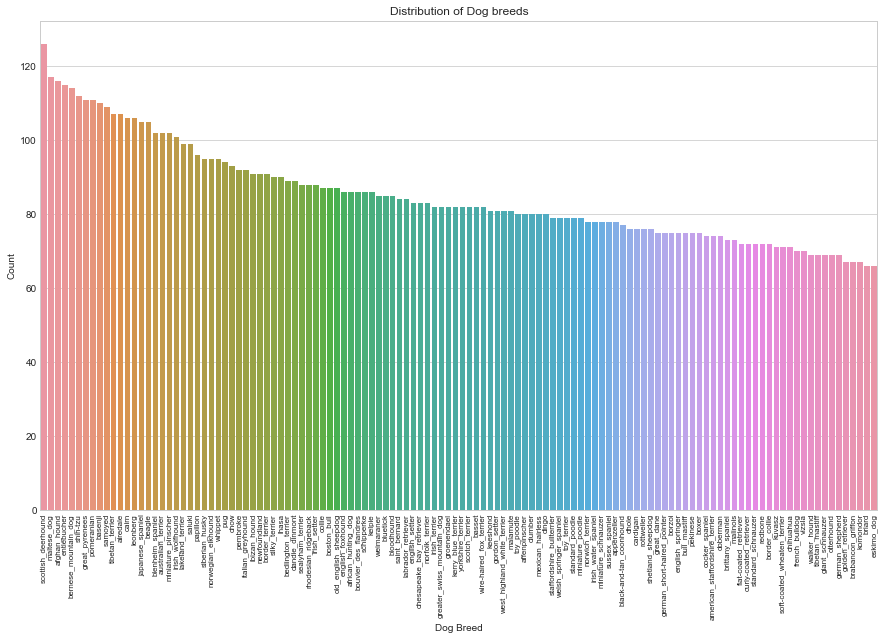

In [11]:
import seaborn as sns
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

yy = pd.value_counts(labels['breed'])

fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
sns.set_style("whitegrid")

ax = sns.barplot(x = yy.index, y = yy, data = labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
ax.set(xlabel='Dog Breed', ylabel='Count')
ax.set_title('Distribution of Dog breeds')
plt.show()

In [12]:
yy.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [13]:
yy.tail()

golden_retriever     67
brabancon_griffon    67
komondor             67
briard               66
eskimo_dog           66
Name: breed, dtype: int64

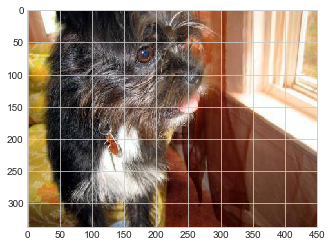

In [14]:
p1=os.listdir('train_val_test/train/affenpinscher')[0]
img = plt.imshow(plt.imread('train_val_test/train/affenpinscher/' + p1))
img.set_cmap('hot')

C:\Users\cuiti\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


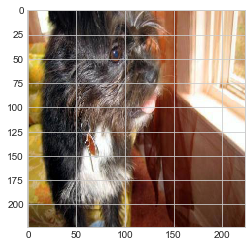

In [15]:
from skimage.transform import resize

img = plt.imshow(resize(plt.imread('train_val_test/train/affenpinscher/' + p1), (224, 224)))
img.set_cmap('hot')

## Build model from the scratch

### small first try model

#### build the model layer by layer using keras

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, concatenate
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model

def small_first_try_model(input_shape):
    input_img = Input(shape = input_shape)
    # First Conv 2D layer
    conv_1 = Conv2D(16, (2,2), padding='valid',activation='relu')(input_img)
    # Max Pooling Layer
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    # Second Conv 2D layer
    conv_2 = Conv2D(32, (2,2),padding='valid',activation='relu')(maxpool1)
    # Max Pooling Layer
    maxpool2 = MaxPooling2D((2,2))(conv_2)
    # Third Conv 2D layer
    conv_3 = Conv2D(64,(2,2), padding='valid',activation='relu')(maxpool2)
    # Max Pooling Layer
    maxpool3 = MaxPooling2D((2,2))(conv_3)
    # Global Average Pooling Layer
    globalavgpool = GlobalAveragePooling2D()(maxpool3)
    # Fully Connected Layer
    out = Dense(120, activation='softmax')(globalavgpool)
    model = Model(inputs = input_img, outputs = out)
    return model

In [17]:
# Set the input_shape
input_shape = (224, 224, 3)

model = small_first_try_model(input_shape)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 64)        0         
__________

#### model training

In [ ]:
from keras.callbacks import ModelCheckpoint  

### you can specify the number of epochs that you would like to use to train the model.
epochs = 10

checkpointer = ModelCheckpoint(filepath='weights.best.small_first_try.hdf5',
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets,
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

#### model prediction

In [66]:
model.load_weights('weights.best.small_first_try.hdf5')

print('For training set:')
report_accuracy(train_tensors, train_targets)

print('For validation set:')
report_accuracy(val_tensors, val_targets)

print('For test set:')
report_accuracy(test_tensors, test_targets)

For training set:
The Number of Test images are: 8185
Test accuracy: 1.3684%
For validation set:
The Number of Test images are: 1015
Test accuracy: 0.9852%
For test set:
The Number of Test images are: 1022
Test accuracy: 0.9785%


## Small_inception

#### build model

In [18]:
# Include inception layer
def small_inception(input_shape):
    #LeNet based inception layer model will be used.
    input_img = Input(shape = input_shape)
    # First Convolution Layer
    conv_1 = Conv2D(4, (5,5), strides =(1,1), padding='same', activation='relu')(input_img)
    # Max Pool Layer
    maxpool1 = MaxPooling2D((2,2))(conv_1)
    # Second Conv layer
    conv_2 = Conv2D(4, (3,3), strides=(2,2), padding='same', activation='relu')(maxpool1)
    # First inception Layer
    path1_1 = Conv2D(8, (1,1), padding='same', activation='relu')(conv_2)
    path1_1 = Conv2D(8, (3,3), padding='same', activation='relu')(path1_1)
    path1_2 = Conv2D(8, (1,1), padding='same', activation='relu')(conv_2)
    path1_2 = Conv2D(8, (5,5), padding='same', activation='relu')(path1_2)
    path1_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(conv_2)
    path1_3 = Conv2D(8, (1,1), padding='same', activation='relu')(path1_3)
    inception_out1 = concatenate([path1_1, path1_2, path1_3], axis = 3)
    maxpool2 = MaxPooling2D((2,2))(inception_out1)
    interim_1 = Conv2D(4, (1,1), padding='same', activation='relu')(maxpool2)
    fc1 = Flatten()(interim_1)
    out = Dense(120, activation='softmax')(fc1)
    model = Model(inputs = input_img, outputs = out)
    return model

In [19]:
# Set the input_shape
input_shape = (224, 224, 3)

model = small_inception(input_shape)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 224, 224, 4)  304         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 4)  0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 56, 56, 4)    148         max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_6 (

#### model training

In [ ]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.
epochs = 10

checkpointer = ModelCheckpoint(filepath='weights.best.small_inception.hdf5',
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets,
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

#### model prediction

In [20]:
model.load_weights('weights.best.small_inception.hdf5')

print('For training set:')
report_accuracy(train_tensors, train_targets)

print('For validation set:')
report_accuracy(val_tensors, val_targets)

print('For test set:')
report_accuracy(test_tensors, test_targets)

For training set:
The Number of Test images are: 8185
Test accuracy: 9.3952%
For validation set:
The Number of Test images are: 1015
Test accuracy: 3.2512%
For test set:
The Number of Test images are: 1022
Test accuracy: 3.0333%


# Big_inception

In [21]:
# Try to double the number of channels in each layer.
def big_inception(input_shape):
    #LeNet based inception layer model will be used.
    input_img = Input(shape = input_shape)
    # First Convolution Layer
    conv_1 = Conv2D(8, (5,5), strides =(2,2), padding='valid', activation='relu')(input_img)
    # Max Pool Layer
    maxpool1 = MaxPooling2D((3,3), strides=(1,1), padding='valid')(conv_1)
    # Second Conv layer
    conv_2 = Conv2D(8, (5,5), strides=(2,2), padding='valid', activation='relu')(maxpool1)
    # First inception Layer
    path1_1 = Conv2D(16, (1,1), padding='same', activation='relu')(conv_2)
    path1_1 = Conv2D(16, (3,3), padding='same', activation='relu')(path1_1)
    path1_2 = Conv2D(16, (1,1), padding='same', activation='relu')(conv_2)
    path1_2 = Conv2D(16, (5,5), padding='same', activation='relu')(path1_2)
    path1_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(conv_2)
    path1_3 = Conv2D(16, (1,1), padding='same', activation='relu')(path1_3)
    inception_out1 = concatenate([path1_1, path1_2, path1_3], axis = 3)
    maxpool2 = MaxPooling2D((3,3), strides=(1,1), padding='valid')(inception_out1)
    interim_1 = Conv2D(8, (1,1), padding='same', activation='relu')(maxpool2)
    fc1 = Flatten()(interim_1)
    out = Dense(120, activation='softmax')(fc1)
    model = Model(inputs = input_img, outputs = out)
    return model

In [22]:
# Set the input_shape
input_shape = (224, 224, 3)

model = big_inception(input_shape)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 110, 110, 8)  608         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 108, 108, 8)  0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 52, 52, 8)    1608        max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
conv2d_14 

#### model training

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 10

checkpointer = ModelCheckpoint(filepath='weights.best.big_inception.hdf5',
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets,
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

#### model prediction

In [23]:
model.load_weights('weights.best.big_inception.hdf5')

print('For training set:')
report_accuracy(train_tensors, train_targets)

print('For validation set:')
report_accuracy(val_tensors, val_targets)

print('For test set:')
report_accuracy(test_tensors, test_targets)

For training set:
The Number of Test images are: 8185
Test accuracy: 1.2340%
For validation set:
The Number of Test images are: 1015
Test accuracy: 1.1823%
For test set:
The Number of Test images are: 1022
Test accuracy: 1.2720%


## Final scratch model

#### model training

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# dimensions of our images
img_width, img_height = 224, 224
train_data_dir = 'train_val_test/train'
validation_data_dir = 'train_val_test/val'
nb_train_samples = 8185
nb_validation_samples = 1015
epochs = 20
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(120))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 52, 52, 64)        18496     
__________

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing: only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('final_scratch.h5')

#### model prediction

In [26]:
model.load_weights('final_scratch.h5')

print('For training set:')
report_accuracy(train_tensors, train_targets)

print('For validation set:')
report_accuracy(val_tensors, val_targets)

print('For test set:')
report_accuracy(test_tensors, test_targets)

For training set:
The Number of Test images are: 8185
Test accuracy: 10.2138%
For validation set:
The Number of Test images are: 1015
Test accuracy: 8.1773%
For test set:
The Number of Test images are: 1022
Test accuracy: 6.8493%
